In [2]:
import pandas as pd
import numpy as np
from anndata import AnnData
import scanpy as sc
import scipy.sparse as sp
from tqdm import tqdm
from paste import pairwise_align
import ot
import torch
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import anndata as ad

In [3]:
dataset_path = '/home/hanyuji/Workbench/ST/ST_data_check/paste_alignment_cortex/PASTE_align/cortex_macaque1_119slice_subset_1000spot_2000gene_HVG.h5ad'
adata = sc.read_h5ad(dataset_path)

In [4]:
unique_batches = adata.obs['batch'].unique()
adata_list = [adata[adata.obs['batch'] == batch].copy() for batch in unique_batches]

In [5]:
def get_edge_index(M):
    # 将稠密矩阵M转换为稀疏矩阵，并获得边的索引edge_index 
    M_ = coo_matrix(M) # 稠密矩阵--->稀疏矩阵
    values = M_.data
    indices = np.vstack((M_.row, M_.col))  # 我们真正需要的coo形式
    return indices

In [5]:
torch.cuda.set_device(1)  # 将设备设置为 'cuda:0'

import pickle
dir = '/home/hanyuji/Workbench/ST/ST_data_check/paste_alignment_cortex/PASTE_align/'  # 保存的位置


all_pairwise_index = []
for i in tqdm(range(len(adata_list)-1)):
# for i in tqdm(range(3)):

    pi = pairwise_align(sliceA=adata_list[i],sliceB=adata_list[i+1], backend = ot.backend.TorchBackend(), use_gpu = False, numItermax=50000)
    edge_index = get_edge_index(pi)
    all_pairwise_index.append(edge_index)
    

'''保存变量'''
with open(dir + 'pairwise_index_1000spot_0715.pkl', 'wb') as file:
    pickle.dump(all_pairwise_index, file)
print('all_pairwise_index saved')

  0%|          | 0/118 [00:00<?, ?it/s]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  1%|          | 1/118 [00:02<04:21,  2.24s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  2%|▏         | 2/118 [00:06<06:53,  3.57s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  3%|▎         | 3/118 [00:13<09:38,  5.03s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  3%|▎         | 4/118 [00:17<09:02,  4.76s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  4%|▍         | 5/118 [00:23<09:24,  4.99s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  5%|▌         | 6/118 [00:27<08:41,  4.65s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  6%|▌         | 7/118 [00:29<07:21,  3.98s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  7%|▋         | 8/118 [00:34<07:28,  4.08s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  8%|▊         | 9/118 [00:36<06:42,  3.69s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  8%|▊         | 10/118 [00:41<07:02,  3.91s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


  9%|▉         | 11/118 [00:47<07:59,  4.48s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 10%|█         | 12/118 [00:51<07:51,  4.45s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 11%|█         | 13/118 [00:54<06:45,  3.86s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 12%|█▏        | 14/118 [00:57<06:35,  3.80s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 13%|█▎        | 15/118 [01:02<06:49,  3.97s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 14%|█▎        | 16/118 [01:06<07:07,  4.19s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 14%|█▍        | 17/118 [01:10<06:46,  4.03s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 15%|█▌        | 18/118 [01:16<07:31,  4.51s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 16%|█▌        | 19/118 [01:19<06:51,  4.15s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 17%|█▋        | 20/118 [01:23<06:51,  4.20s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 18%|█▊        | 21/118 [01:30<08:05,  5.01s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 19%|█▊        | 22/118 [01:36<08:26,  5.28s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 19%|█▉        | 23/118 [01:41<08:10,  5.16s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 20%|██        | 24/118 [01:50<10:10,  6.50s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 21%|██        | 25/118 [01:57<09:56,  6.42s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 22%|██▏       | 26/118 [02:04<10:04,  6.57s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 23%|██▎       | 27/118 [02:14<11:47,  7.77s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 24%|██▎       | 28/118 [02:22<11:39,  7.78s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 25%|██▍       | 29/118 [02:34<13:15,  8.94s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 25%|██▌       | 30/118 [02:40<11:51,  8.09s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 26%|██▋       | 31/118 [02:48<11:35,  8.00s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 27%|██▋       | 32/118 [02:55<11:08,  7.78s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 28%|██▊       | 33/118 [02:58<09:13,  6.51s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 29%|██▉       | 34/118 [03:04<08:56,  6.38s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 30%|██▉       | 35/118 [03:07<07:09,  5.17s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 31%|███       | 36/118 [03:11<06:47,  4.97s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 31%|███▏      | 37/118 [03:16<06:46,  5.02s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 32%|███▏      | 38/118 [03:21<06:25,  4.82s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 33%|███▎      | 39/118 [03:25<05:58,  4.53s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 34%|███▍      | 40/118 [03:30<06:23,  4.91s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 35%|███▍      | 41/118 [03:37<07:00,  5.46s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 36%|███▌      | 42/118 [03:42<06:32,  5.17s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 36%|███▋      | 43/118 [03:49<07:23,  5.91s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 37%|███▋      | 44/118 [03:53<06:36,  5.36s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 38%|███▊      | 45/118 [04:01<07:12,  5.93s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 39%|███▉      | 46/118 [04:17<10:55,  9.10s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 40%|███▉      | 47/118 [04:23<09:29,  8.03s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 41%|████      | 48/118 [04:37<11:43, 10.05s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 42%|████▏     | 49/118 [04:50<12:25, 10.80s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 42%|████▏     | 50/118 [04:59<11:31, 10.17s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 43%|████▎     | 51/118 [05:09<11:31, 10.32s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 44%|████▍     | 52/118 [05:16<10:11,  9.27s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 45%|████▍     | 53/118 [05:29<11:21, 10.48s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 46%|████▌     | 54/118 [05:34<09:23,  8.80s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 47%|████▋     | 55/118 [05:41<08:25,  8.03s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 47%|████▋     | 56/118 [05:44<06:58,  6.75s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 48%|████▊     | 57/118 [05:53<07:26,  7.31s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 49%|████▉     | 58/118 [06:01<07:32,  7.54s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 50%|█████     | 59/118 [06:06<06:32,  6.66s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 51%|█████     | 60/118 [06:13<06:42,  6.93s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 52%|█████▏    | 61/118 [06:21<06:55,  7.28s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 53%|█████▎    | 62/118 [06:24<05:31,  5.92s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 53%|█████▎    | 63/118 [06:27<04:29,  4.90s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 54%|█████▍    | 64/118 [06:30<03:58,  4.41s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 55%|█████▌    | 65/118 [06:38<04:50,  5.48s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 56%|█████▌    | 66/118 [06:43<04:46,  5.51s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 57%|█████▋    | 67/118 [06:53<05:43,  6.74s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 58%|█████▊    | 68/118 [07:28<12:37, 15.14s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 58%|█████▊    | 69/118 [07:37<10:56, 13.40s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 59%|█████▉    | 70/118 [07:52<11:03, 13.81s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 60%|██████    | 71/118 [08:10<11:54, 15.20s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 61%|██████    | 72/118 [08:33<13:23, 17.47s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 62%|██████▏   | 73/118 [09:04<16:10, 21.56s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 63%|██████▎   | 74/118 [09:14<13:15, 18.08s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 64%|██████▎   | 75/118 [09:31<12:41, 17.71s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 64%|██████▍   | 76/118 [09:49<12:26, 17.77s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 65%|██████▌   | 77/118 [10:03<11:26, 16.73s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 66%|██████▌   | 78/118 [10:05<08:10, 12.27s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 67%|██████▋   | 79/118 [10:27<09:49, 15.12s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 68%|██████▊   | 80/118 [10:37<08:42, 13.75s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 69%|██████▊   | 81/118 [10:44<07:10, 11.63s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 69%|██████▉   | 82/118 [10:59<07:32, 12.58s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 70%|███████   | 83/118 [11:09<06:50, 11.73s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 71%|███████   | 84/118 [11:34<09:02, 15.95s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 72%|███████▏  | 85/118 [11:57<09:56, 18.08s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 73%|███████▎  | 86/118 [12:12<09:03, 16.97s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 74%|███████▎  | 87/118 [12:20<07:21, 14.24s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 75%|███████▍  | 88/118 [12:30<06:30, 13.00s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 75%|███████▌  | 89/118 [12:40<05:49, 12.06s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 76%|███████▋  | 90/118 [12:44<04:33,  9.76s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 77%|███████▋  | 91/118 [12:47<03:31,  7.84s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 78%|███████▊  | 92/118 [12:59<03:51,  8.89s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 79%|███████▉  | 93/118 [13:14<04:26, 10.67s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 80%|███████▉  | 94/118 [13:18<03:29,  8.75s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 81%|████████  | 95/118 [13:24<03:05,  8.07s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 81%|████████▏ | 96/118 [13:41<03:53, 10.63s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 82%|████████▏ | 97/118 [13:50<03:33, 10.15s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 83%|████████▎ | 98/118 [14:06<03:58, 11.93s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 84%|████████▍ | 99/118 [14:11<03:07,  9.84s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 85%|████████▍ | 100/118 [14:18<02:39,  8.83s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 86%|████████▌ | 101/118 [14:29<02:43,  9.62s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 86%|████████▋ | 102/118 [14:38<02:29,  9.37s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 87%|████████▋ | 103/118 [14:45<02:09,  8.66s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 88%|████████▊ | 104/118 [14:55<02:06,  9.03s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 89%|████████▉ | 105/118 [15:10<02:20, 10.81s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 90%|████████▉ | 106/118 [15:27<02:33, 12.78s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 91%|█████████ | 107/118 [15:33<01:58, 10.78s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 92%|█████████▏| 108/118 [15:38<01:29,  8.94s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 92%|█████████▏| 109/118 [15:42<01:08,  7.62s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 93%|█████████▎| 110/118 [15:47<00:52,  6.59s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 94%|█████████▍| 111/118 [15:51<00:40,  5.84s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 95%|█████████▍| 112/118 [15:55<00:33,  5.55s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 96%|█████████▌| 113/118 [15:59<00:24,  4.85s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 97%|█████████▋| 114/118 [16:05<00:21,  5.25s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 97%|█████████▋| 115/118 [16:10<00:15,  5.24s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 98%|█████████▊| 116/118 [16:21<00:13,  6.85s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


 99%|█████████▉| 117/118 [16:27<00:06,  6.62s/it]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


100%|██████████| 118/118 [16:34<00:00,  8.43s/it]

all_pairwise_index saved


In [7]:
all_pairwise_index

[array([[  0,   1,   2, ..., 997, 998, 999],
        [697,  31, 419, ..., 755, 950, 524]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [617, 961, 298, ..., 804, 311, 162]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [411, 930, 477, ..., 373, 578, 648]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [658, 346, 313, ..., 930,   7, 261]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [425, 965, 215, ...,  67, 928,  92]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [460, 766, 306, ..., 946, 824, 541]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [323, 262,   8, ..., 816, 255, 263]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [934, 778, 966, ..., 353, 325, 491]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [800, 722, 442, ..., 202, 414, 351]], dtype=int32),
 array([[  0,   1,   2, ..., 997, 998, 999],
        [5

In [13]:
def track_sequence(start, arrays):
    # start是起始数字，arrays是数组列表
    path = [start]  # 轨迹起始
    current = start
    for arr in arrays:
        idx = np.where(arr[0] == current)[0][0]  # 找到current在第一维的位置
        current = arr[1][idx]  # 获取该位置在第二维的对应数字
        path.append(current)  # 添加到路径中
    return path


# 跟踪所有起始数字的轨迹
paths = np.array([track_sequence(i, all_pairwise_index) for i in range(1000)])


'''保存变量'''
np.save(dir + 'cortex_macaque1_track_sequence_1000spot.npy', paths)
print('paths saved')


paths saved


In [1]:
paths[42]

NameError: name 'paths' is not defined

# 保存结果

In [6]:
'''加载变量'''

import pickle
dir = '/home/hanyuji/Workbench/ST/ST_data_check/paste_alignment_cortex/PASTE_align/'  # 保存的位置

# with open(dir + 'pairwise_index_5000spot_0713.pkl', 'rb') as file:
#     all_pairwise_index = pickle.load(file)

paths = np.load(dir + 'cortex_macaque1_track_sequence_1000spot.npy')



In [7]:
paths

array([[  0, 697, 133, ..., 665, 601,  45],
       [  1,  31, 223, ..., 801,  50, 358],
       [  2, 419, 368, ..., 553, 323, 504],
       ...,
       [997, 755, 968, ...,  17, 886, 980],
       [998, 950, 955, ..., 383, 999, 879],
       [999, 524, 364, ..., 390, 235, 228]])

# 可视化

In [8]:
slice =[adata_list[i] for i in range(0,6)]
coo_all =[ slice[i].obsm['spatial'] for i in range(0,6)]


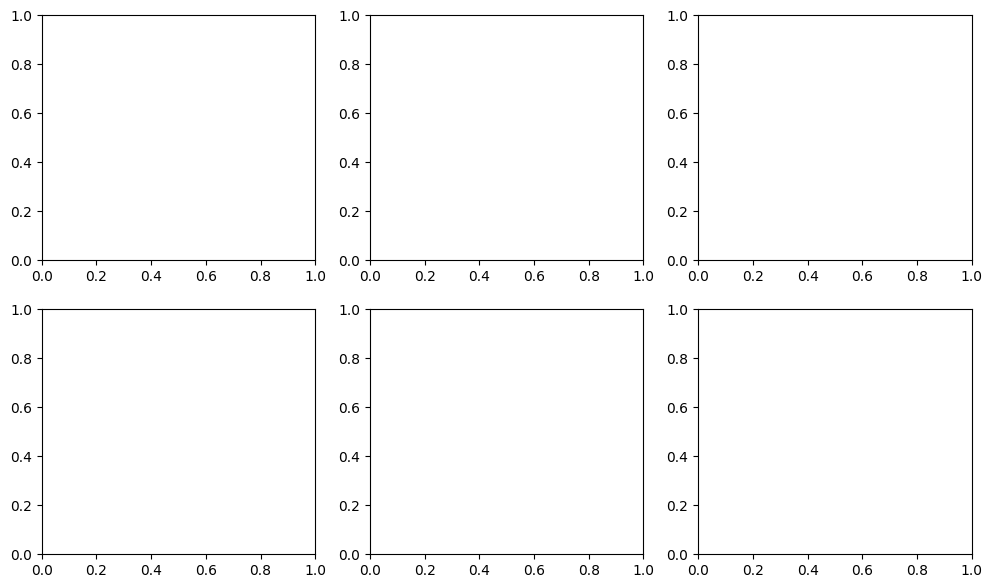

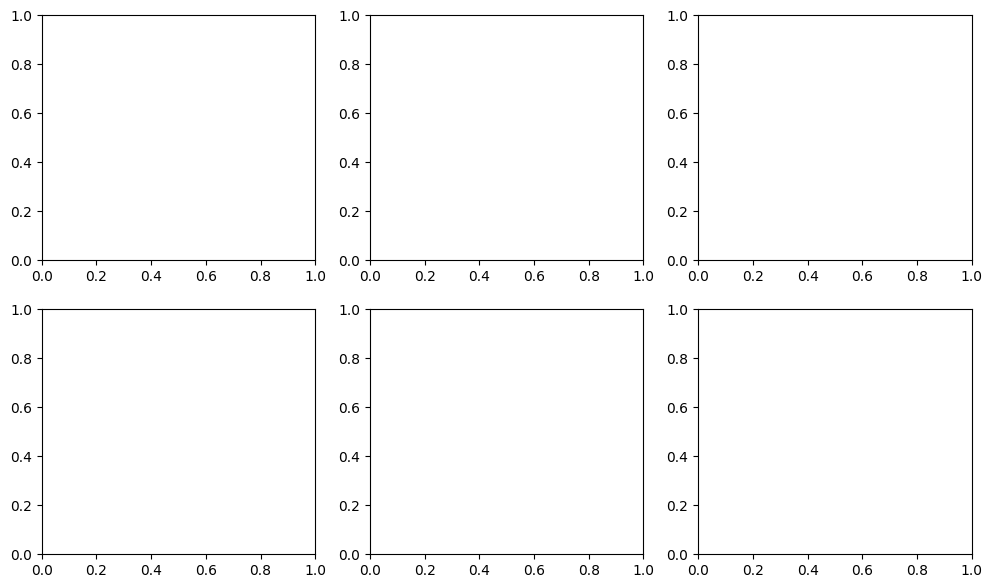

In [20]:
axs = plt.subplots(2, 3, figsize=(12, 7))
axs[i]

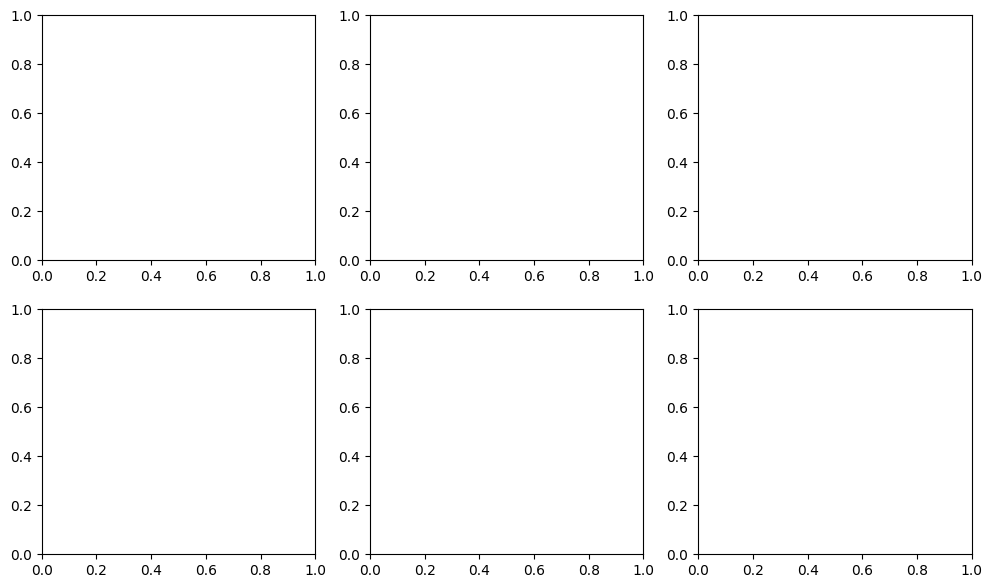

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

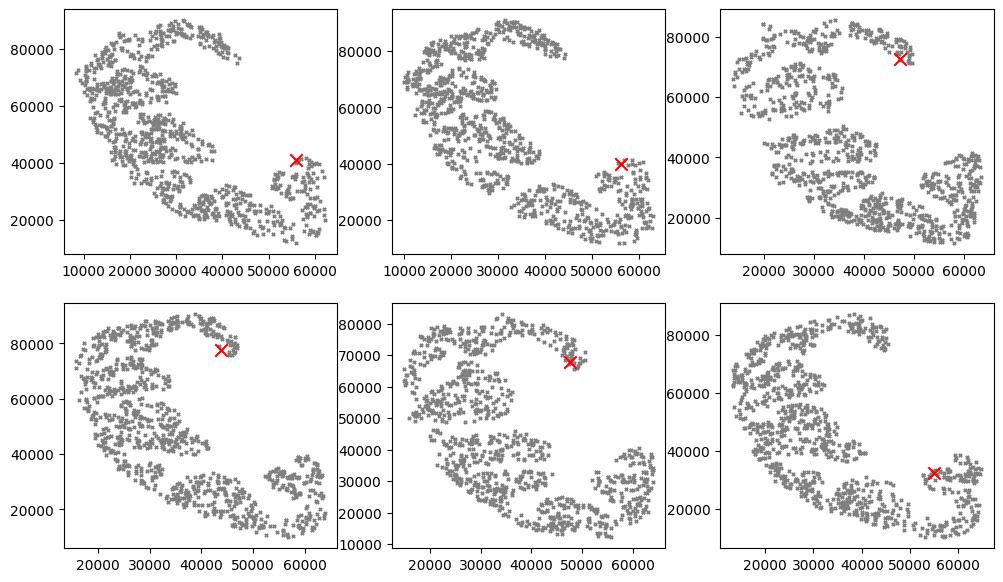

In [27]:
def plt_aligned_point(choiced_index):
    '''
    随机选取两个对齐的spot
    展示两个点的坐标
    持续1s
    '''

    aligned_point = [coo_all[i][paths[choiced_index,i]] for i in range(0,6)]

    fig, axs = plt.subplots(2, 3, figsize=(12, 7))
    
    # 背景
    for i in range(6):
        if i<3:
            axs[0, i].scatter(coo_all[i][:, 0], coo_all[i][:, 1], c='gray', marker='x',s=5)
        else:
            axs[1, i-3].scatter(coo_all[i][:, 0], coo_all[i][:, 1], c='gray', marker='x',s=5)

    # 对齐的两个点
    for i in range(6):
        if i<3:
            axs[0, i].scatter(aligned_point[i][0], aligned_point[i][1], c='r', marker='x',s=80)
        else:
            axs[1, i-3].scatter(aligned_point[i][0], aligned_point[i][1], c='r', marker='x',s=80)

    plt.show()
    # display(plt.gcf())
    time.sleep(1)  # 等待1秒钟
    clear_output(wait=True)


import time
from IPython.display import clear_output, display

for i in range(15):
    choiced_index = np.random.randint(1000)
    plt_aligned_point(choiced_index)


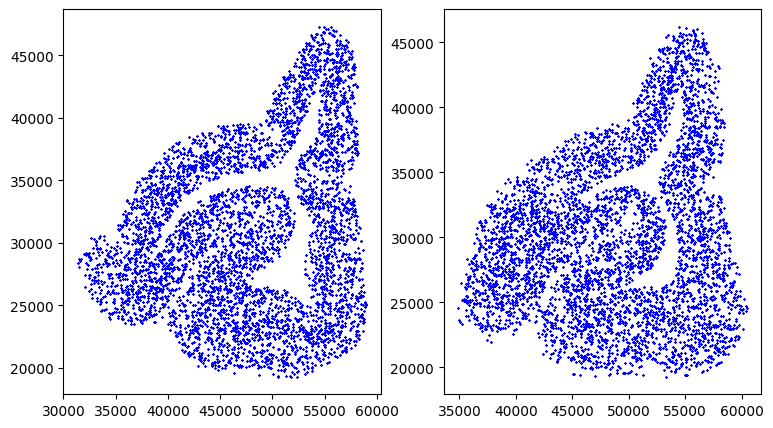

In [22]:
import matplotlib.pyplot as plt

s0_1 = [slice_0,slice_1]
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i, ax in enumerate(axs.flat):
    coo = pd.DataFrame(s0_1[i].obsm['spatial'])
    ax.scatter(coo[0], coo[1], c='b', marker='x',s=1)

plt.show()